In [1]:
# import the necessary packages
import numpy as np
import argparse
import cv2
import glob
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Initialize the haarcascade classifier for face detection
cascade_file_src = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascade_file_src)

In [350]:
# Some command line arguments are needed to be able to execute the deep learning model for face detection
args = {
    "prototxt": "deploy.prototxt.txt",
    "model": "res10_300x300_ssd_iter_140000.caffemodel",
    }
args

{'model': 'res10_300x300_ssd_iter_140000.caffemodel',
 'prototxt': 'deploy.prototxt.txt'}

In [351]:
# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])

[INFO] loading model...


In [378]:
# A test picture is read
image= cv2.imread('test/paintball.jpg')
image.shape

(1125, 2085, 3)

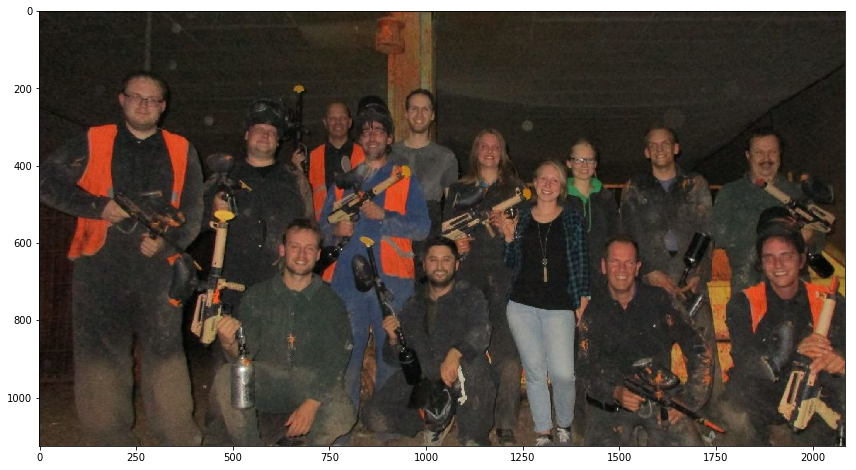

In [379]:
# The picture is a typical example of the result of a cheap camera. 
# A limited flash results in much noise and faces on a distance that are difficult to detect
fig=plt.figure(figsize=(16, 8))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(np.asarray(image))

## First experiment: deep learning

In [380]:
def ext_faces(image):
    # Determine dimensions of picture
    (h, w) = image.shape[:2]
    # Prepare the image for the network
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the detections and
    # predictions
    net.setInput(blob)
    detections = net.forward()
    faces =[]
    print('# detections found: ',detections.shape[2])
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the prediction
        confidence = detections[0, 0, i, 2]
        # filter out weak detections by ensuring the `confidence` is greater than the minimum confidence.
        # To detect a maximum number of pictures confidence is pretty low. Lower confidences lead to errors. 
        if confidence > 0.15: 
            # compute the (x, y)-coordinates of the bounding box for the
            # object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            #print(box)
            (startX, startY, endX, endY) = box.astype("int")
            img = cv2.rectangle(image,(startX,startY),(endX,endY),(255,0,0),2)
            img = image[startY:endY, startX:endX]
            face = cv2.resize(img,((224,224)))
            faces.append(face)
    return(faces)
            

In [381]:
facecrop = ext_faces(image)
print('# faces above with confidence above 0.15: ', len(facecrop))

# detections found:  171
# faces above with confidence above 0.15:  7


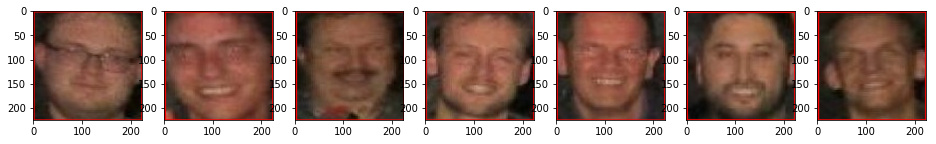

In [382]:
fig=plt.figure(figsize=(16, 8))
n=1
for face in facecrop:
        fig.add_subplot(1,len(facecrop),n)
        #face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        plt.imshow(np.asarray(face))
        n=n+1 

7 out of 14 faces are detected (50%). But no false positives.

## Experiment 2: Haarcascade

In [388]:
def ext_faces2(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # detect faces
    # scaleFactor and minNeighbours are low to detect as much as possible faces
    # Clarification properties: http://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Object_Detection_Face_Detection_Haar_Cascade_Classifiers.php
    faces = faceCascade.detectMultiScale(gray, 1.1, 2)
    print('# faces found:',len(faces))
    facecrop = []
    # crop right area
    for f in faces:
            x, y, w, h = [ v for v in f ]
            facecrop.append(image[y:y+h, x:x+w])
    facecrop2 = []
    # resize to right number of pixels
    for face in facecrop:
        crpim = cv2.resize(face,((224,224)))
        facecrop2.append(crpim)
    return facecrop2

In [389]:
facecrop2 = ext_faces2(image)


# faces found: 18


18

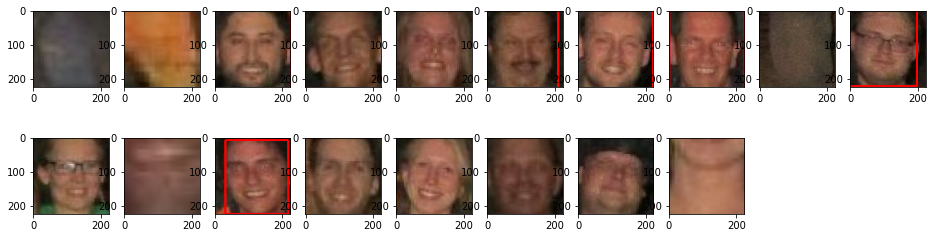

In [390]:
fig=plt.figure(figsize=(16,16))
n=1
row = 7
for face in facecrop2:
        fig.add_subplot(row,10,n)
        #face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        plt.imshow(np.asarray(face))
        n=n+1 

13 out of 14 faces are detected (92%). Unfortunately 5 false positives are found.

## Experiment 3: Searching with haarcascade and confirming with deep learning

In [422]:
def ext_faces3(image):
    # First haarcascade is used to find faces (with many false positives)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 2)
    print('# faces found:',len(faces))
    facecrop = []
    # The faces are cropped and the resulting images are fed in a sequence to the neural net.
    for f in faces:
        x, y, w, h = [ v for v in f ]
        facecrop.append(image[y:y+h, x:x+w])
    confirmed = []
    for img in facecrop:    
        blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
        net.setInput(blob)
        detections = net.forward()
        print(detections[0, 0, 0, 2])
        # A probability threshold of 0.15 is used (learned from experiment 1)
        if detections[0, 0, 0, 2] > 0.15:
            face = cv2.resize(img,((224,224)))
            confirmed.append(face)
    return(confirmed)
            

In [423]:
facecrop3 = ext_faces3(image)
len(facecrop3)

# faces found: 18
0.13111837
0.9151432
0.9712644
0.9181378
0.99274045
0.99873835
0.9840185
0.13300344
0.16581835
0.12830524
0.12309178
0.66482174
0.9999254
0.99883157
0.96079004
0.9991203
0.16141388
0.9314175


14

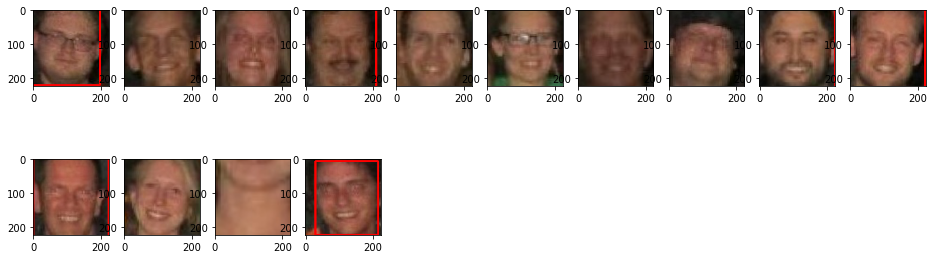

In [424]:
fig=plt.figure(figsize=(16,16))
n=1
for face in facecrop3:
        fig.add_subplot(6,10,n)
        #face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        plt.imshow(np.asarray(face))
        n=n+1 

The result now  is again 13/14 (92%). Only one false positive (or rather a bad selection of the right face).